In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install gradio==3.35.2

INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 

In [4]:
pip install tensorflow pillow numpy

Prediction Results:
Predicted Class: Blurry
Confidence: 99.43%
Clinical Priority: 1.5x

Detailed Class Probabilities:
Blurry: 0.9943
Normal: 0.0051
Moderate: 0.0005
Severe: 0.0001
Malignant: 0.0000


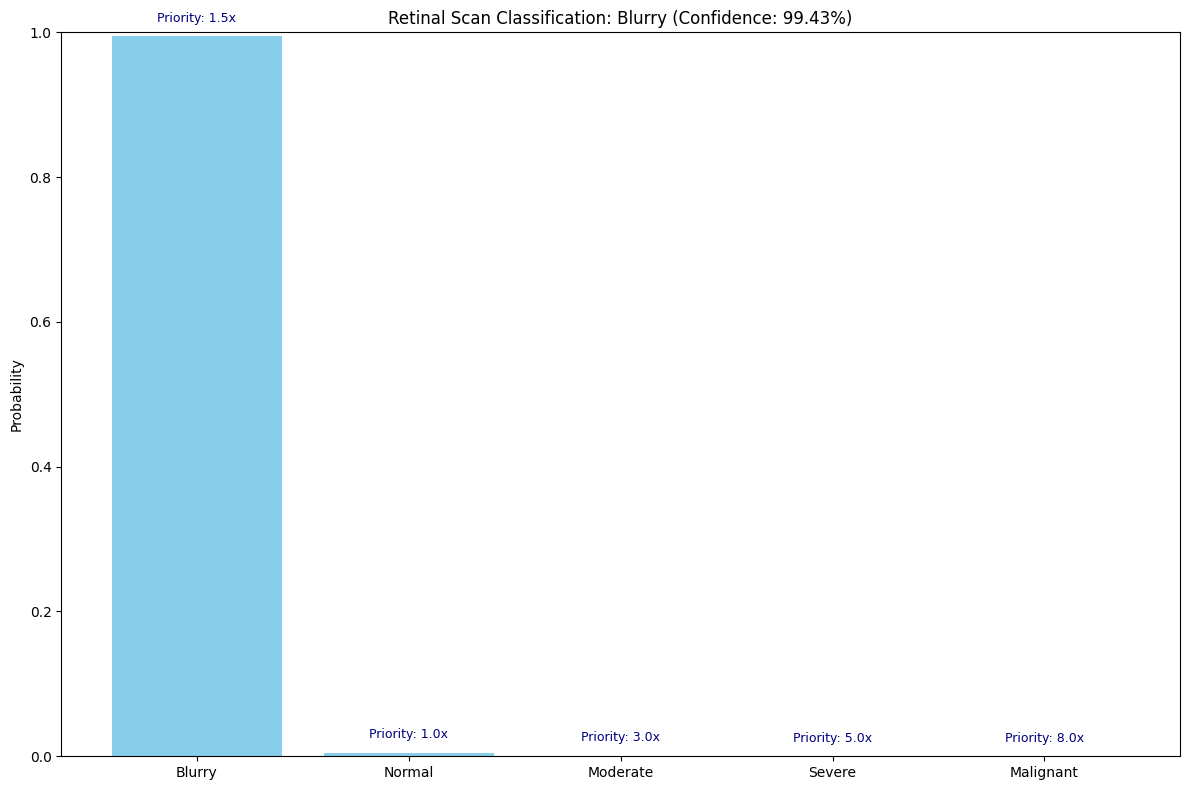

In [4]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

# Define custom attention mechanism for model loading
from tensorflow.keras import layers

def channel_attention(input_tensor):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    shared_layer = layers.Dense(filters//8, activation='relu')
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    avg_pool = layers.Reshape((1, 1, filters))(avg_pool)
    avg_pool = shared_layer(avg_pool)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    max_pool = layers.Reshape((1, 1, filters))(max_pool)
    max_pool = shared_layer(max_pool)
    attention = layers.Add()([avg_pool, max_pool])
    attention = layers.Conv2D(filters, 1, activation='sigmoid')(attention)
    return layers.Multiply()([input_tensor, attention])

# Load the model with custom objects
model_path = '/content/drive/MyDrive/models/best_model.keras'
model = load_model(model_path, custom_objects={'channel_attention': channel_attention})

# Class names
class_names = ['Blurry', 'Normal', 'Moderate', 'Severe', 'Malignant']

# Image path to predict
image_path = r'/content/drive/MyDrive/dataset/test_pdr/Class_0/2204_right.jpg'

# Load and preprocess image
img = Image.open(image_path)
if img.mode != 'RGB':
    img = img.convert('RGB')
img = img.resize((224, 224))
img_array = np.array(img).astype(np.float32)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Predict
predictions = model.predict(img_array, verbose=0)[0]
predicted_class = np.argmax(predictions)
confidence = float(predictions[predicted_class])

# Clinical classification based on class weights
class_weights = {
    0: 1.5,  # Blurry
    1: 1.0,  # Normal
    2: 3.0,  # Moderate
    3: 5.0,  # Severe
    4: 8.0   # Malignant
}

# Prepare result
result = {
    'Predicted Class': class_names[predicted_class],
    'Confidence': f"{confidence:.2%}",
    'Clinical Priority': f"{class_weights[predicted_class]}x"
}

print("Prediction Results:")
print(f"Predicted Class: {result['Predicted Class']}")
print(f"Confidence: {result['Confidence']}")
print(f"Clinical Priority: {result['Clinical Priority']}")
print("\nDetailed Class Probabilities:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {predictions[i]:.4f}")


# Interactive visualization
fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(class_names, predictions, color='skyblue')
ax.set_ylim(0, 1)
ax.set_ylabel('Probability')
ax.set_title(f'Retinal Scan Classification: {result["Predicted Class"]} (Confidence: {result["Confidence"]})')

# Add clinical priority annotations
for i, (prob, weight) in enumerate(zip(predictions, class_weights.values())):
    ax.text(i, prob+0.02, f'Priority: {weight}x',
            ha='center', color='navy', fontsize=9)

# Interactive hover effects
cursor = Cursor(ax, horizOn=False, vertOn=True, color='red', linewidth=1)

def on_move(event):
    if event.inaxes == ax:
        for bar in bars:
            if bar.contains(event)[0]:
                bar.set_color('tomato')
                bar.set_alpha(0.9)
            else:
                bar.set_color('skyblue')
                bar.set_alpha(1)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', on_move)
plt.tight_layout()
plt.show()
